In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvas
from scipy.spatial import distance
import random
import pickle
from scipy import stats

# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

save_path="/Users/aloreggia/Documents/img_experiment_neurips"

In [2]:
import max_ent.examples.grid_9_by_9 as G
from max_ent.utility.support import *


from max_ent.gridworld import Directions
%matplotlib notebook
random.seed(123)
np.random.seed(123)

# Nominal world

[LEFT, DOWN_RIGHT]


<IPython.core.display.Javascript object>


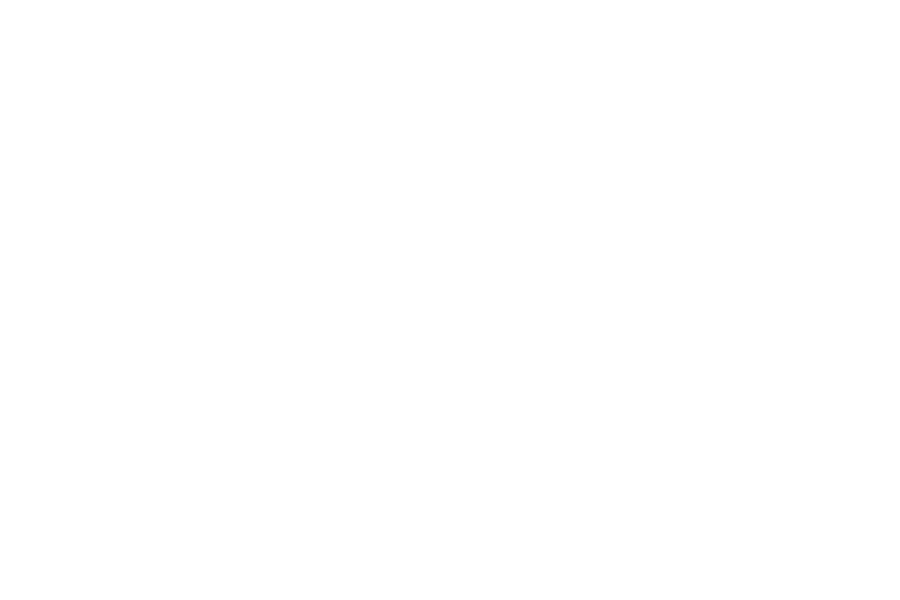

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x115db8470>}


<IPython.core.display.Javascript object>


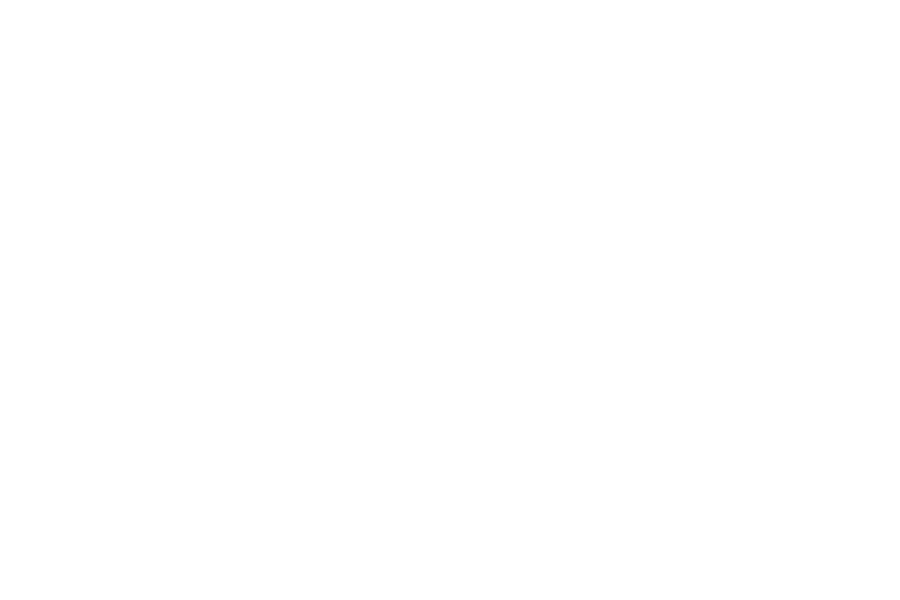

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x115db8470>}
MAE(best):  0.070544960865829
MAE(best):  0.011326614594949
MAE(best):  0.011168411053333
MAE(best):  0.010896088831049
Finished with MAE(best):  0.009975709331747
number of world: 0
[UP, DOWN]
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x115db8470>}
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x115db8470>}
MAE(best):  0.168966960837118
MAE(best):  0.039939199564358
MAE(best):  0.039939199564358
MAE(best):  0.030615321983067
MAE(best):  0.020514495425588
Finished with MAE(best):  0.018075719113560
number of world: 1


In [3]:
n_tests = 2
show = False

if show:
    fig = plt.figure(figsize=(9, 5 * n_tests))
    axis = fig.subplots(n_tests, 3)


worlds =[]
nominal_matrix=[]
constrained_matrix=[]
learned_matrix=[]
greedy_matrix=[]
random_matrix=[]

# GENERATE n_tests NOMINAL WORLDS
i = 0
while i < n_tests:
    
    blue, green, cs, ca, start, goal = generate_constraints(9)
    print(ca)

    
    n, n_cfg, demo_n, f1 = create_world('Nominal', blue, green, start=start, goal=goal)

    
    
    #cs = [31, 39, 41, 47, 51]  # constrained states
    #ca = [Directions.UP_LEFT, Directions.UP_RIGHT]  # constrained actions
    cc = [1, 2]  # constrained colors

    c, c_cfg, demo_c, f2 = create_world('Constrained', blue, green, cs, ca, cc, start=start, goal=goal, check=True)
    
    #CHECK WHETHER STATE AND GOAL ARE REACHABLE - IF NOT SKIP THE GRID AND GENERATE A NEW ONE
    if c != None:
        if show: 
            axis[y].imshow(X)
            fig = plt.figure(figsize=(15, 5 * 1))
            axis = fig.subplots(1, 3)
            plt.ioff()
            plt.close()
            plt.ion()
            canvas = FigureCanvas(f1)
            canvas.draw()
            X = np.array(canvas.renderer.buffer_rgba())

            x = 0
            y = 0 
            axis[y].axis('off')   
            axis[y].set_title(f'Nominal {i}', fontsize=7)
            plt.close()
            plt.ion()
            canvas = FigureCanvas(f2)
            canvas.draw()
            X = np.array(canvas.renderer.buffer_rgba())

            x = 0
            y = 1 
            axis[y].axis('off')   
            axis[y].set_title(f'Constrained {i}', fontsize=7)
            axis[y].imshow(X)

        learned_params = G.learn_constraints(n.reward, c.world, c.terminal, demo_c.trajectories)
        learned_mdp = G.MDP(c.world, learned_params.reward, c.terminal, c.start)
        demo_l = G.generate_trajectories(c.world, learned_params.reward, c.start, c.terminal)
        

        #FIRST COMPUTE STATISTICS FOR NOMINAL WORLD TRAJECTORIES IN LEARNED CONSTRAINED WORLD
        temp_matrix, avg_length, avg_reward, avg_reward_n, avg_violated, counters = count_states(demo_n.trajectories, learned_mdp, n_cfg.mdp, {'blue': blue, 'green': green, 'cs':cs, 'ca':ca})
        nominal_matrix.append({i: {'temp_matrix': temp_matrix, 'demo': demo_n, 'avg_length': avg_length, 'avg_reward':avg_reward, 'avg_reward_n':avg_reward_n, 'avg_violated': avg_violated, 'counters': counters}})

        #THEN COMPUTE STATISTICS FOR CONSTRAINED WORLD TRAJECTORIES IN LEARNED CONSTRAINED WORLD
        temp_matrix, avg_length, avg_reward, avg_reward_n, avg_violated, counters = count_states(demo_c.trajectories, learned_mdp, n_cfg.mdp, {'blue': blue, 'green': green, 'cs':cs, 'ca':ca})
        constrained_matrix.append({i: {'temp_matrix': temp_matrix, 'demo': demo_c, 'avg_length': avg_length, 'avg_reward':avg_reward, 'avg_reward_n':avg_reward_n, 'avg_violated': avg_violated, 'counters': counters}})

        #THEN COMPUTE STATISTICS FOR CONSTRAINED WORLD TRAJECTORIES IN LEARNED CONSTRAINED WORLD    
        temp_matrix, avg_length, avg_reward, avg_reward_n, avg_violated, counters = count_states(demo_l.trajectories, learned_mdp, n_cfg.mdp, {'blue': blue, 'green': green, 'cs':cs, 'ca':ca})
        learned_matrix.append({i: {'temp_matrix': temp_matrix, 'demo': demo_l, 'avg_length': avg_length, 'avg_reward':avg_reward, 'avg_reward_n':avg_reward_n, 'avg_violated': avg_violated, 'counters': counters}})

        demo_greedy = G.generate_greedy_trajectories(c.world, n.reward, learned_params.reward, c.start, c.terminal)
        temp_matrix, avg_length, avg_reward, avg_reward_n, avg_violated, counters = count_states(demo_greedy.trajectories, learned_mdp, n_cfg.mdp, {'blue': blue, 'green': green, 'cs':cs, 'ca':ca})
        greedy_matrix.append({i: {'temp_matrix': temp_matrix, 'demo': demo_greedy, 'avg_length': avg_length, 'avg_reward':avg_reward, 'avg_reward_n':avg_reward_n, 'avg_violated': avg_violated, 'counters':counters}})
        
        demo_random = G.generate_random_trajectories(c.world, c.start, c.terminal)
        temp_matrix, avg_length, avg_reward, avg_reward_n, avg_violated, counters = count_states(demo_random.trajectories, learned_mdp, n_cfg.mdp, {'blue': blue, 'green': green, 'cs':cs, 'ca':ca})
        random_matrix.append({i: {'temp_matrix': temp_matrix, 'demo': demo_random, 'avg_length': avg_length, 'avg_reward':avg_reward, 'avg_reward_n':avg_reward_n, 'avg_violated': avg_violated, 'counters':counters}})
        
        #print(c.world)
        #rl_matrix, avg_rl, avg_reward, avg_violated = count_states(demo_l[0], c)
        #print(avg_reward)
        #print(avg_violated)

        if show: 
            p = G.plot_world('Learned Constrained', learned_mdp, learned_params.state_weights, 
                          learned_params.action_weights, learned_params.color_weights, 
                          demo_l, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)

            plt.close()
            plt.ion()
            canvas = FigureCanvas(p)
            canvas.draw()
            X = np.array(canvas.renderer.buffer_rgba())

            x = 0
            y = 2 
            axis[y].axis('off')   
            axis[y].set_title(f'Learned {i}', fontsize=7)
        if show: 
            axis[y].imshow(X)
            fig.tight_layout()
            fig.savefig(os.path.join(save_path, f"nominal_{i}.png")) 

        print(f"number of world: {i}")
        
        worlds.append({'n': n_cfg,'c': c_cfg,'learned_params': learned_params,'learned_mdp': learned_mdp, \
                       'demo_n': demo_n, 'demo_c': demo_c, 'demo_l': demo_l, 'constraints': {'blue': blue, 'green': green, 'cs':cs, 'ca':ca}})
        i +=1




## Learn constraints

In [4]:
wrl_matrix = []   

#[n, c, learned_params, learned_mdp]

for test in range(n_tests):
    if show:
        fig = plt.figure(figsize=(15, 15))
        axis = fig.subplots(4, 3)

    n_cfg = worlds[test]['n']
    c_cfg = worlds[test]['c']
    constraints = worlds[test]['constraints']
    n = n_cfg.mdp
    c = c_cfg.mdp
    learned_params = worlds[test]['learned_params']
    learned_mdp = worlds[test]['learned_mdp']
    
    wrl_matrix.append([])

    for i in range(11):
        w = [(i)/10, 1 - (i)/10]
        demo_wrl = G.generate_weighted_average_trajectories(n.world, n.reward, learned_params.reward, n.start, n.terminal, w)
        temp_matrix, avg_length, avg_reward, avg_reward_n, avg_violated, counters = count_states(demo_wrl.trajectories, c, n, constraints)

        wrl_matrix[test].append({i: {'temp_matrix': temp_matrix, 'demo': demo_wrl, 'avg_length': avg_length, 'avg_reward':avg_reward, 'avg_reward_n':avg_reward_n, 'avg_violated': avg_violated, 'counters': counters}})
        
        if show:
            plt.ioff()
            f1 = G.plot_world(f'w = ({w[0]:0.1f}, {w[1]:0.1f})', learned_mdp, learned_params.state_weights, 
                          learned_params.action_weights, learned_params.color_weights, 
                          demo_wrl, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
            plt.close()
            plt.ion()
            canvas = FigureCanvas(f1)
            canvas.draw()
            X = np.array(canvas.renderer.buffer_rgba())

            x = i // 3
            y = i % 3
            axis[x,y].axis('off')   
            axis[x,y].set_title(f'w = ({w[0]:0.1f}, {w[1]:0.1f})', fontsize=14)
            axis[x,y].imshow(X)



    if show:
        fig.tight_layout()
        fig.savefig(os.path.join(save_path, f"wrl_{test}.png")) 

## MDFT as orchestrator

In [5]:
mdft_matrix = []   

#[n, c, learned_params, learned_mdp]

for test in range(n_tests):
    if show:
        fig = plt.figure(figsize=(15, 15))
        axis = fig.subplots(4, 3)

    n_cfg = worlds[test]['n']
    c_cfg = worlds[test]['c']
    constraints = worlds[test]['constraints']
    n = n_cfg.mdp
    c = c_cfg.mdp
    learned_params = worlds[test]['learned_params']
    learned_mdp = worlds[test]['learned_mdp']
    
    mdft_matrix.append([])
    
    for i in range(11):
        w = [(i)/10, 1 - (i)/10]
        demo_mdft = G.generate_mdft_trajectories(c.world, n.reward, learned_params.reward, c.start, c.terminal, w)

        #temp_matrix, avg_mdft, avg_reward, avg_violated = count_states(demo_mdft[0], c)
        temp_matrix, avg_length, avg_reward, avg_reward_n, avg_violated, counters = count_states(demo_mdft.trajectories, learned_mdp, n_cfg.mdp, constraints)
        mdft_matrix[test].append({i: {'temp_matrix': temp_matrix, 'demo': demo_mdft, 'avg_length': avg_length, 'avg_reward':avg_reward, 'avg_reward_n':avg_reward_n, 'avg_violated': avg_violated, 'counters':counters}})
        
        if show:
            plt.ioff()
            f1 = G.plot_world(f'w = ({w[0]:0.1f}, {w[1]:0.1f})', learned_mdp, learned_params.state_weights, 
                          learned_params.action_weights, learned_params.color_weights, 
                          demo_mdft, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)
            plt.close()
            plt.ion()
            canvas = FigureCanvas(f1)
            canvas.draw()
            X = np.array(canvas.renderer.buffer_rgba())

            x = i // 3
            y = i % 3
            axis[x,y].axis('off')   
            axis[x,y].set_title(f'w = ({w[0]:0.1f}, {w[1]:0.1f})', fontsize=14)
            axis[x,y].imshow(X)


    if show:
        fig.tight_layout()
        fig.savefig(os.path.join(save_path, f"mdft_{test}.png")) 

In [6]:
nominal_matrix[0][0]["avg_reward"]

-26.535957626329154

In [34]:
endline="&"
import pandas as pd
df = pd.DataFrame()

print(f"W {endline} AVG LENGTH MDFT {endline} AVG LENGTH WRL {endline} AVG REWARD MDFT {endline} AVG REWARD WRL {endline} AVG VC MDFT {endline} AVG VC WRL {endline} AVG JS DIST \\\\")
temp_dict = compute_statistics_grid(nominal_matrix, constrained_matrix, learned_matrix, nominal_matrix, worlds, n_tests, "nominal")
temp_df_nominal = pd.DataFrame(data=temp_dict)

temp_dict = compute_statistics_grid(nominal_matrix, constrained_matrix, learned_matrix, constrained_matrix, worlds, n_tests, "constrained")
temp_df_constrained = pd.DataFrame(data=temp_dict)

temp_dict = compute_statistics_grid(nominal_matrix, constrained_matrix, learned_matrix, greedy_matrix, worlds, n_tests, "greedy")
temp_df_greedy = pd.DataFrame(data=temp_dict)

temp_dict = compute_statistics_grid(nominal_matrix, constrained_matrix, learned_matrix, random_matrix, worlds, n_tests, "random")
temp_df_random = pd.DataFrame(data=temp_dict)

for i in range(11):
   
    w = [(i)/10, 1 - (i)/10]
    print(f'({w[0]:0.1f}, {w[1]:0.1f})', end=endline)

    
    temp_dict = compute_statistics(nominal_matrix, constrained_matrix, learned_matrix, mdft_matrix, worlds, n_tests, i, "mdft")
    temp_df_mdft = pd.DataFrame(data=temp_dict)
    
    temp_dict = compute_statistics(nominal_matrix, constrained_matrix, learned_matrix, wrl_matrix, worlds, n_tests, i, "wrl")
    temp_df_wrl = pd.DataFrame(data=temp_dict)
    
     
    df = pd.concat([df, temp_df_nominal, temp_df_constrained, temp_df_mdft, temp_df_wrl,temp_df_greedy, temp_df_random], ignore_index = True)
    #print(avg_js_divergence)
    #print(f"\t{np.mean(avg_length_mdft):0.2f} ($\\pm$ {conf_interval(avg_length_mdft):0.2f})", end=endline) 
    #print(f"{np.mean(avg_length_wrl):0.2f} ($\\pm$ {conf_interval(avg_length_wrl):0.2f})", end=endline)
    #print(f"{np.mean(avg_rew_mdft):0.2f} ($\\pm$ {conf_interval(avg_rew_mdft):0.2f})", end=endline) 
    ##print(f"{np.mean(avg_rew_wrl):0.2f} ($\\pm$ {conf_interval(avg_rew_wrl):0.2f})", end=endline)
    #print(f"{np.mean(avg_vc_mdft):0.2f} ($\\pm$ {conf_interval(avg_vc_mdft):0.2f})", end=endline) 
    #print(f"{np.mean(avg_vc_wrl):0.2f} ($\\pm$ {conf_interval(avg_vc_wrl):0.2f})", end=endline)
    #print(f"KL(RL||MDFT) {kl_divergence(p,q)} \t KL(MDFT||RL) {kl_divergence(q,p)}")
    #print(f"JS(RL||MDFT) {np.mean(avg_js_divergence):0.4f} ({np.std(avg_js_divergence):0.4f}) \t JS DISTANCE {np.mean(avg_js_distance):0.4f} ({np.std(avg_js_distance):0.4f})", endline="\n")
    #print(f"{np.mean(avg_js_distance):0.2f} ($\\pm$ {conf_interval(avg_js_distance):0.2f})", end="\\\\\n")
    #print("---------------------------------------------------------\n")

df.to_csv('statistics.csv')

W & AVG LENGTH MDFT & AVG LENGTH WRL & AVG REWARD MDFT & AVG REWARD WRL & AVG VC MDFT & AVG VC WRL & AVG JS DIST \\
(0.0, 1.0)&

/Users/aloreggia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(0.1, 0.9)&(0.2, 0.8)&(0.3, 0.7)&(0.4, 0.6)&(0.5, 0.5)&(0.6, 0.4)&(0.7, 0.3)&(0.8, 0.2)&(0.9, 0.1)&(1.0, 0.0)&

In [63]:
import seaborn as sns
%matplotlib inline
label = "avg_norm_length"
label_nominal = "avg_length"

fig=plt.figure(figsize=(12, 7))
#sns.set(font_scale=1.5)
#sns.color_palette("white", as_cmap=True)
#sns.relplot(x="i", y="avg_vc", hue="type", kind="line", ci="sd", data=df);
sns.set_style("white")
g = sns.barplot(x="i", y=label, hue="type", data=df.loc[(df['type']!="constrained") & (df['type']!="nominal") & (df['type']!="wrl")], palette="autumn", ci=95);
g.set_xticks(range(11)) # <--- set the ticks first
g.set_xticklabels([f"({(i)/10:0.1f}, {1 - (i)/10:0.1f})" for i in range(11)])


avg_min_nominal_length = df["avg_min_nominal_length"] 

constrained_avg_norm_length= np.mean([learned_matrix[i][i][label_nominal]/avg_min_nominal_length] for i in range(n_tests)])
nominal_avg_norm_length= np.mean([nominal_matrix[i][i][label_nominal]/avg_min_nominal_length] for i in range(n_tests)])

greedy_avg_norm_length= np.mean(df.loc[(df['type']=='greedy')][label])
random_avg_norm_length= np.mean(df.loc[(df['type']=='random')][label])


#constrained_avg_norm_length= np.mean([learned_matrix[i][i][label_nominal]/learned_matrix[i][i][label_nominal] for i in range(n_tests)])
#nominal_avg_norm_length= np.mean([nominal_matrix[i][i][label_nominal]/learned_matrix[i][i][label_nominal] for i in range(n_tests)])

g.axhline(constrained_avg_norm_length, color='r', linestyle='--', label="constrained")
g.axhline(nominal_avg_norm_length, color='b', linestyle='--', label="nominal")

g.axhline(greedy_avg_norm_length, color='g', linestyle='-.', label="greedy")
#g.axhline(random_avg_norm_length, color='g', linestyle=':', label="random")

plt.legend()
plt.grid(alpha=0.3)

plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("W(Nominal, Constraints)")
plt.ylabel("Avg Reward")


plt.show()
fig.savefig(os.path.join(save_path, f"{label}.png"), bbox_inches = 'tight') 

SyntaxError: invalid syntax (<ipython-input-63-c68327c12997>, line 18)

In [20]:
df.loc[(df['type']!="constrained") & (df['type']!="nominal")]

,avg_js_dist_constrained,avg_js_dist_nominal,avg_js_div_constrained,avg_js_div_nominal,avg_length,avg_min_nominal_length,avg_norm_length,avg_norm_reward,avg_norm_vc,avg_reward,avg_vc,i,type
0,0.320479,0.555177,0.148175,0.444670,4.445,4.5,1.481667,0.981270,1.250000,-13.272640,0.225,0.0,mdft
1,0.295732,0.651249,0.126175,0.611884,7.165,4.5,1.194167,0.966837,0.521127,-31.710065,0.185,0.0,mdft
2,0.703073,0.731537,0.713140,0.772053,44.350,4.5,14.783333,69.786064,86.444444,-943.925286,15.560,0.0,wrl
3,0.676888,0.690228,0.661010,0.687322,71.115,4.5,11.852500,49.467665,75.619718,-1622.427476,26.845,0.0,wrl
4,0.697233,0.484615,0.701342,0.338820,3.355,4.5,1.118333,1.638492,6.777778,-22.162222,1.220,NaN,greedy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.693748,0.302268,0.694350,0.131813,6.785,4.5,1.130833,2.618902,15.225352,-85.894057,5.405,10.0,mdft
62,0.666128,0.655655,0.640162,0.620191,21.370,4.5,7.123333,34.919581,45.305556,-472.321747,8.155,10.0,wrl
63,0.673819,0.625937,0.655029,0.565243,37.000,4.5,6.166667,31.988646,52.183099,-1049.155202,18.525,10.0,wrl
64,0.697233,0.484615,0.701342,0.338820,3.355,4.5,1.118333,1.638492,6.777778,-22.162222,1.220,NaN,greedy


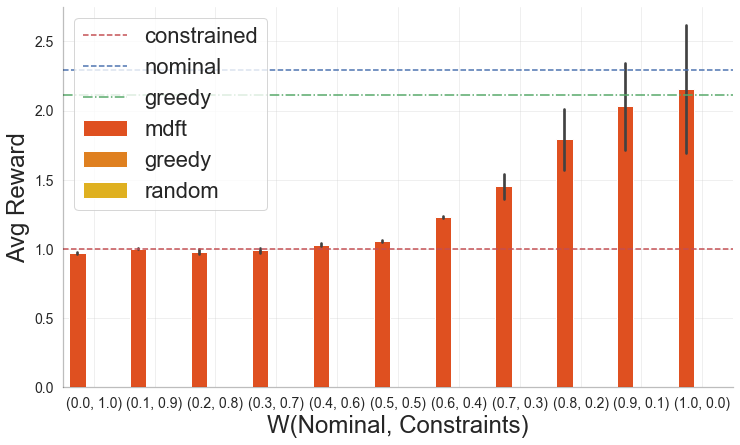

In [57]:
import seaborn as sns
%matplotlib inline
label = "avg_norm_reward"
label_nominal = "avg_reward"

fig=plt.figure(figsize=(12, 7))
#sns.set(font_scale=1.5)
#sns.color_palette("white", as_cmap=True)
#sns.relplot(x="i", y="avg_vc", hue="type", kind="line", ci="sd", data=df);
sns.set_style("white")
g = sns.barplot(x="i", y=label, hue="type", data=df.loc[(df['type']!="constrained") & (df['type']!="nominal") & (df['type']!="wrl")], palette="autumn", ci=95);
g.set_xticks(range(11)) # <--- set the ticks first
g.set_xticklabels([f"({(i)/10:0.1f}, {1 - (i)/10:0.1f})" for i in range(11)])

constrained_avg_norm_length= np.mean([learned_matrix[i][i][label_nominal]/learned_matrix[i][i][label_nominal] for i in range(n_tests)])
nominal_avg_norm_length= np.mean([nominal_matrix[i][i][label_nominal]/learned_matrix[i][i][label_nominal] for i in range(n_tests)])

greedy_avg_norm_length= np.mean(df.loc[(df['type']=='greedy')][label])
random_avg_norm_length= np.mean(df.loc[(df['type']=='random')][label])


#constrained_avg_norm_length= np.mean([learned_matrix[i][i][label_nominal]/learned_matrix[i][i][label_nominal] for i in range(n_tests)])
#nominal_avg_norm_length= np.mean([nominal_matrix[i][i][label_nominal]/learned_matrix[i][i][label_nominal] for i in range(n_tests)])

g.axhline(constrained_avg_norm_length, color='r', linestyle='--', label="constrained")
g.axhline(nominal_avg_norm_length, color='b', linestyle='--', label="nominal")

g.axhline(greedy_avg_norm_length, color='g', linestyle='-.', label="greedy")
#g.axhline(random_avg_norm_length, color='g', linestyle=':', label="random")

plt.legend()
plt.grid(alpha=0.3)

plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("W(Nominal, Constraints)")
plt.ylabel("Avg Reward")


plt.show()
fig.savefig(os.path.join(save_path, f"{label}.png"), bbox_inches = 'tight') 

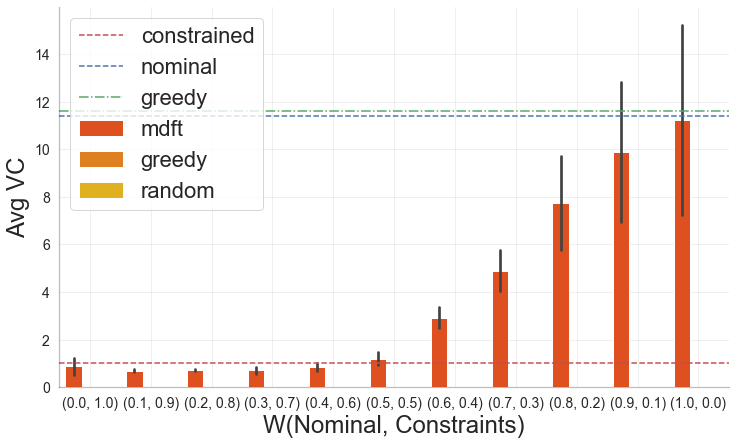

In [59]:
import seaborn as sns
%matplotlib inline
label = "avg_norm_vc"
label_nominal = "avg_violated"

fig=plt.figure(figsize=(12, 7))
#sns.set(font_scale=1.5)
#sns.color_palette("white", as_cmap=True)
#sns.relplot(x="i", y="avg_vc", hue="type", kind="line", ci="sd", data=df);
sns.set_style("white")
g = sns.barplot(x="i", y=label, hue="type", data=df.loc[(df['type']!="constrained") & (df['type']!="nominal") & (df['type']!="wrl")], palette="autumn", ci=95);
g.set_xticks(range(11)) # <--- set the ticks first
g.set_xticklabels([f"({(i)/10:0.1f}, {1 - (i)/10:0.1f})" for i in range(11)])

constrained_avg_norm_length= np.mean([learned_matrix[i][i][label_nominal]/learned_matrix[i][i][label_nominal] for i in range(n_tests)])
nominal_avg_norm_length= np.mean([nominal_matrix[i][i][label_nominal]/learned_matrix[i][i][label_nominal] for i in range(n_tests)])

greedy_avg_norm_length= np.mean(df.loc[(df['type']=='greedy')][label])
random_avg_norm_length= np.mean(df.loc[(df['type']=='random')][label])


#constrained_avg_norm_length= np.mean([learned_matrix[i][i][label_nominal]/learned_matrix[i][i][label_nominal] for i in range(n_tests)])
#nominal_avg_norm_length= np.mean([nominal_matrix[i][i][label_nominal]/learned_matrix[i][i][label_nominal] for i in range(n_tests)])

g.axhline(constrained_avg_norm_length, color='r', linestyle='--', label="constrained")
g.axhline(nominal_avg_norm_length, color='b', linestyle='--', label="nominal")

g.axhline(greedy_avg_norm_length, color='g', linestyle='-.', label="greedy")
#g.axhline(random_avg_norm_length, color='g', linestyle=':', label="random")

plt.legend()
plt.grid(alpha=0.3)

plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("W(Nominal, Constraints)")
plt.ylabel("Avg VC")


plt.show()
fig.savefig(os.path.join(save_path, f"{label}.png"), bbox_inches = 'tight') 

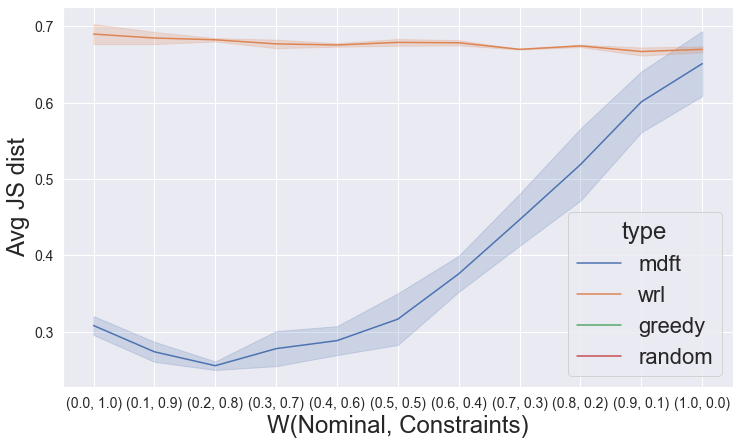

In [60]:
fig=plt.figure(figsize=(12, 7))
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="whitegrid")
sns.set(font_scale=2)
sns.color_palette("viridis", as_cmap=True)
#sns.relplot(x="i", y="avg_vc", hue="type", kind="line", ci="sd", data=df);
#g=sns.relplot(x="i", y=[i[0] for i in df['avg_js_dist']],  kind="line", data=df, palette="Greens", height=7, aspect=2);
g=sns.lineplot(x="i", y='avg_js_dist_constrained', data=df.loc[(df['type']!="constrained") & (df['type']!="nominal")], hue="type",markers=True, dashes=False)
g.set_xticklabels([f"({(i)/10:0.1f}, {1 - (i)/10:0.1f})" for i in range(11)])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
g.set_xticks(range(11)) # <--- set the ticks first

plt.xlabel("W(Nominal, Constraints)")
plt.ylabel("Avg JS dist")
plt.show()
fig.savefig(os.path.join(save_path, f"avg_js_dist.png"), bbox_inches = 'tight') 

In [13]:
#learned_params 
#learned_mdp
#demo_l
#n_cfg

In [14]:
for i in range(n_tests):
    print(mdft_matrix[i][0][0]['avg_length']/nominal_matrix[i][i]['avg_length'])
    
np.mean([nominal_matrix[i][i]['avg_length']/nominal_matrix[i][i]['avg_length'] for i in range(n_tests)])
df.loc[df['type']=="mdft"]


1.1853333333333333
0.9623908663532572


,avg_js_dist_constrained,avg_js_dist_nominal,avg_js_div_constrained,avg_js_div_nominal,avg_length,avg_min_nominal_length,avg_norm_length,avg_norm_reward,avg_norm_vc,avg_reward,avg_vc,i,type
0,0.320479,0.555177,0.148175,0.444670,4.445,4.5,1.481667,0.981270,1.250000,-13.272640,0.225,0.0,mdft
1,0.295732,0.651249,0.126175,0.611884,7.165,4.5,1.194167,0.966837,0.521127,-31.710065,0.185,0.0,mdft
6,0.260502,0.559276,0.097903,0.451260,4.485,4.5,1.495000,1.002740,0.750000,-13.563042,0.135,1.0,mdft
7,0.286849,0.651511,0.118709,0.612376,7.365,4.5,1.227500,1.003253,0.633803,-32.904436,0.225,1.0,mdft
12,0.249815,0.557538,0.090035,0.448460,4.465,4.5,1.488333,0.996754,0.777778,-13.482079,0.140,2.0,mdft
13,0.261103,0.647541,0.098355,0.604935,7.145,4.5,1.190833,0.961813,0.676056,-31.545282,0.240,2.0,mdft
18,0.254883,0.565450,0.093725,0.461278,4.500,4.5,1.500000,1.010246,0.555556,-13.664566,0.100,3.0,mdft
19,0.300742,0.650333,0.130486,0.610163,7.240,4.5,1.206667,0.972181,0.859155,-31.885353,0.305,3.0,mdft
24,0.269322,0.556069,0.104645,0.446099,4.455,4.5,1.485000,1.021694,0.666667,-13.819425,0.120,4.0,mdft
25,0.307269,0.620481,0.136211,0.555433,7.475,4.5,1.245833,1.039200,1.014085,-34.083424,0.360,4.0,mdft


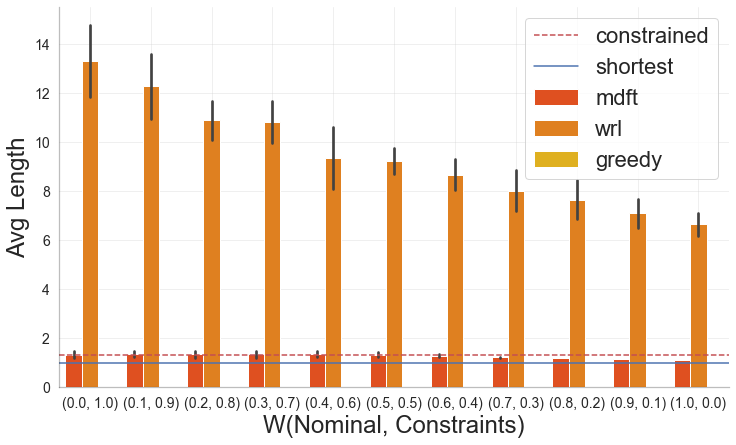

In [15]:
import seaborn as sns
%matplotlib inline
label = "avg_norm_length"
label_nominal = "avg_length"

fig=plt.figure(figsize=(12, 7))
#sns.set(font_scale=1.5)
#sns.color_palette("white", as_cmap=True)
#sns.relplot(x="i", y="avg_vc", hue="type", kind="line", ci="sd", data=df);
sns.set_style("white")
g = sns.barplot(x="i", y=label, hue="type", data=df.loc[(df['type']!="constrained") & (df['type']!="nominal")], palette="autumn", ci=95);
g.set_xticks(range(11)) # <--- set the ticks first
g.set_xticklabels([f"({(i)/10:0.1f}, {1 - (i)/10:0.1f})" for i in range(11)])

avg_min_nominal_length = np.mean([min(map(len,[trajectory.transitions() for trajectory in worlds[test]['demo_n'][0]])) for test in range(n_tests)])

constrained_avg_norm_length= np.mean([learned_matrix[i][i][label_nominal]/avg_min_nominal_length for i in range(n_tests)])
nominal_avg_norm_length= np.mean([nominal_matrix[i][i][label_nominal]/avg_min_nominal_length for i in range(n_tests)])

#constrained_avg_norm_length= np.mean([learned_matrix[i][i][label_nominal]/learned_matrix[i][i][label_nominal] for i in range(n_tests)])
#nominal_avg_norm_length= np.mean([nominal_matrix[i][i][label_nominal]/learned_matrix[i][i][label_nominal] for i in range(n_tests)])

g.axhline(constrained_avg_norm_length, color='r', linestyle='--', label="constrained")
#g.axhline(nominal_avg_norm_length, color='b', linestyle='--', label="nominal")
g.axhline(1.0, color='b', linestyle='-', label="shortest")
plt.legend()
plt.grid(alpha=0.3)

plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("W(Nominal, Constraints)")
plt.ylabel("Avg Length")


plt.show()
fig.savefig(os.path.join(save_path, f"{label}.png"), bbox_inches = 'tight') 

In [16]:
df.loc[(df['type']=="wrl") & (df['i']==8)  & (df['avg_norm_length']<1)]


,avg_js_dist_constrained,avg_js_dist_nominal,avg_js_div_constrained,avg_js_div_nominal,avg_length,avg_min_nominal_length,avg_norm_length,avg_norm_reward,avg_norm_vc,avg_reward,avg_vc,i,type


In [17]:
#print(worlds[0]['demo_c'][0])
#print([trajectory.transitions() for trajectory in worlds[16]['demo_n'][0]])
#l = [trajectory.transitions() for trajectory in worlds[16]['demo_n'][0]]
#min(map(len, l))

#avg_min_nominal_length = np.mean([min(map(len,[trajectory.transitions() for trajectory in worlds[test]['demo_n'][0]])) for test in range(n_tests)])
#print(avg_min_nominal_length)
prova = pd.DataFrame(worlds)

In [61]:
df

,avg_js_dist_constrained,avg_js_dist_nominal,avg_js_div_constrained,avg_js_div_nominal,avg_length,avg_min_nominal_length,avg_norm_length,avg_norm_reward,avg_norm_vc,avg_reward,avg_vc,i,type
0,0.561463,0.000000,0.454795,0.000000,3.750,4.5,1.250000,1.961850,8.444444,-26.535958,1.520,NaN,nominal
1,0.635885,0.000000,0.583354,0.000000,7.445,4.5,1.240833,2.620143,14.366197,-85.934769,5.100,NaN,nominal
2,0.000000,0.561463,0.000000,0.454795,4.610,4.5,1.536667,1.045066,0.250000,-14.135545,0.045,NaN,constrained
3,0.000000,0.635885,0.000000,0.583354,7.485,4.5,1.247500,0.996593,0.408451,-32.686010,0.145,NaN,constrained
4,0.320479,0.555177,0.148175,0.444670,4.445,4.5,1.481667,0.981270,1.250000,-13.272640,0.225,0.0,mdft
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0.673819,0.625937,0.655029,0.565243,37.000,4.5,6.166667,31.988646,52.183099,-1049.155202,18.525,10.0,wrl
128,0.697233,0.484615,0.701342,0.338820,3.355,4.5,1.118333,1.638492,6.777778,-22.162222,1.220,NaN,greedy
129,0.722538,0.542855,0.753174,0.425150,6.870,4.5,1.145000,2.590743,16.408451,-84.970509,5.825,NaN,greedy
130,0.747080,0.748297,0.805210,0.807835,68.325,4.5,22.775000,31.893613,167.166667,-431.392552,30.090,NaN,random
